### Sourcing & Analyzing Time Series Data
### United States Hate Crimes (1991-2018)

#### This script contains the following:

1. Importing your libraries and data
2. Subsetting, wrangling, and cleaning time-series data
3. Time series analysis: decomposition
4. Testing for stationarity

### 1. Importing your libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [3]:
# This option ensures the graphs you create are displayed in your notebook without the need to "call" them specifically.

%matplotlib inline

In [4]:
#defining path

path = '/Users/Ana/Documents/Hate Crimes in the US'

In [5]:
path

'/Users/Ana/Documents/Hate Crimes in the US'

In [30]:
# Import data
df = pd.read_csv(os.path.join(path, 'Prepared dataset', 'hate_crime_wrangled.csv'))

In [31]:
df.head()

Unnamed: 0  INCIDENT_ID  DATA_YEAR        ORI PUB_AGENCY_NAME  \
0           0            2       1991  AZ0072300         Phoenix   
1           1            3       1991  AZ0072300         Phoenix   
2           2            4       1991  AZ0072300         Phoenix   
3           3            5       1991  AZ0072300         Phoenix   
4           4            6       1991  AZ0072300         Phoenix   

  AGENCY_TYPE_NAME STATE_ABBR STATE_NAME DIVISION_NAME REGION_NAME  ...  \
0             City         AZ    Arizona      Mountain        West  ...   
1             City         AZ    Arizona      Mountain        West  ...   
2             City         AZ    Arizona      Mountain        West  ...   
3             City         AZ    Arizona      Mountain        West  ...   
4             City         AZ    Arizona      Mountain        West  ...   

  TOTAL_OFFENDER_COUNT OFFENDER_RACE VICTIM_COUNT  \
0                    0       Unknown            1   
1                    1       Unknown            1   
2                    1       Unknown            1   
3                    1         White            1   
4                    0       Unknown            1   

                               OFFENSE_NAME TOTAL_INDIVIDUAL_VICTIMS  \
0                              Intimidation                      1.0   
1                              Intimidation                      1.0   
2                              Intimidation                      1.0   
3                        Aggravated Assault                      1.0   
4  Destruction/Damage/Vandalism of Property                      0.0   

                        LOCATION_NAME                       BIAS_DESC  \
0                      Residence/Home  Anti-Black or African American   
1      Church/Synagogue/Temple/Mosque                     Anti-Jewish   
2                      Residence/Home                       Anti-Arab   
3  Highway/Road/Alley/Street/Sidewalk  Anti-Black or African American   
4      Church/Synagogue/Temple/Mosque                 Anti-Protestant   

             VICTIM_TYPES MULTIPLE_OFFENSE MULTIPLE_BIAS  
0              Individual                S             S  
1              Individual                S             S  
2              Individual                S             S  
3              Individual                S             S  
4  Religious Organization                S             S  

[5 rows x 23 columns]

In [33]:
# Drop unnecessary columns
df = df.drop(['INCIDENT_ID', 'ORI', 'PUB_AGENCY_NAME', 'AGENCY_TYPE_NAME', 'DIVISION_NAME', 'POPULATION_GROUP_CODE', 'POPULATION_GROUP_DESC', 'LOCATION_NAME', 'VICTIM_TYPES', 'MULTIPLE_OFFENSE', 'MULTIPLE_BIAS'],axis = 1)

In [34]:
# Renaming columns 
new_names = {'DATA_YEAR':'incident_year',
             'STATE_ABBR':'state_abbr',
             'STATE_NAME':'state_name',
             'REGION_NAME':'region_name',
             'INCIDENT_DATE':'incident_date',
             'TOTAL_OFFENDER_COUNT':'offender_count',
             'OFFENDER_RACE':'offender_race',
             'VICTIM_COUNT':'victim_count',
             'OFFENSE_NAME':'offense_type',
             'TOTAL_INDIVIDUAL_VICTIMS':'total_individual_victims',
             'BIAS_DESC':'prejudice'}

df.rename(columns=new_names,inplace=True)

In [35]:
df.head()

Unnamed: 0  incident_year state_abbr state_name region_name incident_date  \
0           0           1991         AZ    Arizona        West     15-JAN-91   
1           1           1991         AZ    Arizona        West     22-JAN-91   
2           2           1991         AZ    Arizona        West     23-JAN-91   
3           3           1991         AZ    Arizona        West     04-FEB-91   
4           4           1991         AZ    Arizona        West     14-FEB-91   

   offender_count offender_race  victim_count  \
0               0       Unknown             1   
1               1       Unknown             1   
2               1       Unknown             1   
3               1         White             1   
4               0       Unknown             1   

                               offense_type  total_individual_victims  \
0                              Intimidation                       1.0   
1                              Intimidation                       1.0   
2                              Intimidation                       1.0   
3                        Aggravated Assault                       1.0   
4  Destruction/Damage/Vandalism of Property                       0.0   

                        prejudice  
0  Anti-Black or African American  
1                     Anti-Jewish  
2                       Anti-Arab  
3  Anti-Black or African American  
4                 Anti-Protestant

In [36]:
# Check for missing values 
df.isnull().sum()

Unnamed: 0                     0
incident_year                  0
state_abbr                     0
state_name                     0
region_name                    0
incident_date                  0
offender_count                 0
offender_race                 19
victim_count                   0
offense_type                   0
total_individual_victims    1606
prejudice                      0
dtype: int64

In [37]:
df['offender_race'].fillna('Unknown',inplace=True)

In [38]:
# Replace with mean (excluding NaN in the calculation)
mean_value = df['total_individual_victims'].mean()
df['total_individual_victims'].fillna(mean_value, inplace=True)

In [39]:
# Check for missing values 
df.isnull().sum()

Unnamed: 0                  0
incident_year               0
state_abbr                  0
state_name                  0
region_name                 0
incident_date               0
offender_count              0
offender_race               0
victim_count                0
offense_type                0
total_individual_victims    0
prejudice                   0
dtype: int64

In [40]:
# Checking for duplicates
dups = df.duplicated()

In [41]:
dups.shape

(201403,)

In [42]:
# Hate Crime Biases  (only showing data for the big racial/identity groups)

hate_crime_victim = df[(df['prejudice'] == 'Anti-American Indian or Alaska Native') 
         | (df['prejudice'] == 'Anti-Arab') 
         | (df['prejudice'] == 'Anti-Asian') 
         | (df['prejudice'] == 'Anti-Black or African American') 
         | (df['prejudice'] == 'Anti-Hispanic or Latino') 
         | (df['prejudice'] == 'Anti-Other Race/Ethnicity/Ancestry') 
         | (df['prejudice'] == 'Anti-Gay (Male)') 
         | (df['prejudice'] == 'Anti-Lesbian(Female)') 
         | (df['prejudice'] == 'Anti-Lesbian, Gay, Bisexual, or Transgender (Mixed Group)') 
         | (df['prejudice'] == 'Anti-Jewish')
         | (df['prejudice'] == 'Anti-Islamic')]

In [43]:
hate_crime_victim.head()

Unnamed: 0  incident_year state_abbr state_name region_name incident_date  \
0           0           1991         AZ    Arizona        West     15-JAN-91   
1           1           1991         AZ    Arizona        West     22-JAN-91   
2           2           1991         AZ    Arizona        West     23-JAN-91   
3           3           1991         AZ    Arizona        West     04-FEB-91   
5           5           1991         AZ    Arizona        West     20-FEB-91   

   offender_count offender_race  victim_count        offense_type  \
0               0       Unknown             1        Intimidation   
1               1       Unknown             1        Intimidation   
2               1       Unknown             1        Intimidation   
3               1         White             1  Aggravated Assault   
5               1       Unknown             1        Intimidation   

   total_individual_victims                       prejudice  
0                       1.0  Anti-Black or African American  
1                       1.0                     Anti-Jewish  
2                       1.0                       Anti-Arab  
3                       1.0  Anti-Black or African American  
5                       1.0  Anti-Black or African American

In [44]:
def nb_check(abbr):
    if abbr == 'NB':
        return 'NE'
    else:
        return abbr

In [45]:
by_state = hate_crime_victim
by_state['state_abbr'] = by_state['state_abbr'].apply(nb_check)

In [46]:
by_state[by_state['state_abbr']=='NE']

Unnamed: 0  incident_year state_abbr state_name region_name  \
35757        35757           1996         NE   Nebraska     Midwest   
35758        35758           1996         NE   Nebraska     Midwest   
35759        35759           1996         NE   Nebraska     Midwest   
44353        44353           1997         NE   Nebraska     Midwest   
44354        44354           1997         NE   Nebraska     Midwest   
...            ...            ...        ...        ...         ...   
198735      198735           2018         NE   Nebraska     Midwest   
198737      198737           2017         NE   Nebraska     Midwest   
198738      198738           2017         NE   Nebraska     Midwest   
198739      198739           2017         NE   Nebraska     Midwest   
198740      198740           2018         NE   Nebraska     Midwest   

       incident_date  offender_count              offender_race  victim_count  \
35757      04-APR-96               1                      White             1   
35758      19-JUL-96               1  Black or African American             1   
35759      21-JUL-96               1  Black or African American             1   
44353      10-JUL-97               0                    Unknown             1   
44354      05-OCT-97               4                      White             4   
...              ...             ...                        ...           ...   
198735     06-JUL-18               0                    Unknown             1   
198737     05-SEP-17               1  Black or African American             1   
198738     31-MAY-17               0                    Unknown             1   
198739     02-DEC-17               1                      White             1   
198740     15-AUG-18               0                    Unknown             1   

                                    offense_type  total_individual_victims  \
35757                             Simple Assault                       1.0   
35758                         Aggravated Assault                       1.0   
35759                         Aggravated Assault                       1.0   
44353   Destruction/Damage/Vandalism of Property                       1.0   
44354                         Aggravated Assault                       4.0   
...                                          ...                       ...   
198735  Destruction/Damage/Vandalism of Property                       0.0   
198737                        Aggravated Assault                       1.0   
198738                              Intimidation                       1.0   
198739                              Intimidation                       1.0   
198740                            Simple Assault                       1.0   

                                                prejudice  
35757                             Anti-Hispanic or Latino  
35758                      Anti-Black or African American  
35759                      Anti-Black or African American  
44353                                         Anti-Jewish  
44354                  Anti-Other Race/Ethnicity/Ancestry  
...                                                   ...  
198735  Anti-Lesbian, Gay, Bisexual, or Transgender (M...  
198737                     Anti-Black or African American  
198738                                    Anti-Gay (Male)  
198739                     Anti-Black or African American  
198740  Anti-Lesbian, Gay, Bisexual, or Transgender (M...  

[745 rows x 12 columns]

In [47]:
hate_crime_victim.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153656 entries, 0 to 201401
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                153656 non-null  int64  
 1   incident_year             153656 non-null  int64  
 2   state_abbr                153656 non-null  object 
 3   state_name                153656 non-null  object 
 4   region_name               153656 non-null  object 
 5   incident_date             153656 non-null  object 
 6   offender_count            153656 non-null  int64  
 7   offender_race             153656 non-null  object 
 8   victim_count              153656 non-null  int64  
 9   offense_type              153656 non-null  object 
 10  total_individual_victims  153656 non-null  float64
 11  prejudice                 153656 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 15.2+ MB


In [48]:
hate_crime_victim['incident_date'] = pd.to_datetime(hate_crime_victim['incident_date'])

In [49]:
hate_crime_victim.head()

Unnamed: 0  incident_year state_abbr state_name region_name incident_date  \
0           0           1991         AZ    Arizona        West    1991-01-15   
1           1           1991         AZ    Arizona        West    1991-01-22   
2           2           1991         AZ    Arizona        West    1991-01-23   
3           3           1991         AZ    Arizona        West    1991-02-04   
5           5           1991         AZ    Arizona        West    1991-02-20   

   offender_count offender_race  victim_count        offense_type  \
0               0       Unknown             1        Intimidation   
1               1       Unknown             1        Intimidation   
2               1       Unknown             1        Intimidation   
3               1         White             1  Aggravated Assault   
5               1       Unknown             1        Intimidation   

   total_individual_victims                       prejudice  
0                       1.0  Anti-Black or African American  
1                       1.0                     Anti-Jewish  
2                       1.0                       Anti-Arab  
3                       1.0  Anti-Black or African American  
5                       1.0  Anti-Black or African American

In [50]:
hate_crime_victim.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153656 entries, 0 to 201401
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Unnamed: 0                153656 non-null  int64         
 1   incident_year             153656 non-null  int64         
 2   state_abbr                153656 non-null  object        
 3   state_name                153656 non-null  object        
 4   region_name               153656 non-null  object        
 5   incident_date             153656 non-null  datetime64[ns]
 6   offender_count            153656 non-null  int64         
 7   offender_race             153656 non-null  object        
 8   victim_count              153656 non-null  int64         
 9   offense_type              153656 non-null  object        
 10  total_individual_victims  153656 non-null  float64       
 11  prejudice                 153656 non-null  object        
dtypes: date

### 2. Subsetting, wrangling, and cleaning time-series data

In [51]:
#create subset 
hate_crime_victims = hate_crime_victim[['incident_date', 'incident_year', 'victim_count']]

Incident date, incident year, and victim count were se;lected in order to see how many victims there were each date and the trend of the number of victims over time.

In [52]:
#sort by year
hate_crime_victims=hate_crime_victims.sort_values(by='incident_date')

In [53]:
hate_crime_victims.head()

incident_date  incident_year  victim_count
450     1991-01-01           1991             1
3716    1991-01-01           1991             1
4398    1991-01-01           1991             1
2530    1991-01-01           1991             1
3069    1991-01-01           1991             2

In [54]:
hate_crime_victims.columns

Index(['incident_date', 'incident_year', 'victim_count'], dtype='object')

In [55]:
hate_crime_victims.set_index('incident_date')

incident_year  victim_count
incident_date                             
1991-01-01              1991             1
1991-01-01              1991             1
1991-01-01              1991             1
1991-01-01              1991             1
1991-01-01              1991             2
...                      ...           ...
2018-12-31              2018             1
2018-12-31              2018             1
2018-12-31              2018             1
2018-12-31              2018             1
2018-12-31              2018             1

[153656 rows x 2 columns]

In [56]:
from datetime import datetime

hate_crime_victims['datetime'] = pd.to_datetime(hate_crime_victims['incident_date']) # Create a datetime column from "Date.""
hate_crime_victims = hate_crime_victims.set_index('datetime') # Set the datetime as the index of the dataframe.
hate_crime_victims.drop(['incident_date'], axis=1, inplace=True) # Drop the "Date" column.
hate_crime_victims.head()

incident_year  victim_count
datetime                               
1991-01-01           1991             1
1991-01-01           1991             1
1991-01-01           1991             1
1991-01-01           1991             1
1991-01-01           1991             2

In [57]:
hate_crime_victims_duplicates = hate_crime_victims[hate_crime_victims.duplicated()]

In [58]:
print(hate_crime_victims_duplicates)

            incident_year  victim_count
datetime                               
1991-01-01           1991             1
1991-01-01           1991             1
1991-01-01           1991             1
1991-01-01           1991             1
1991-01-01           1991             1
...                   ...           ...
2018-12-31           2018             1
2018-12-31           2018             1
2018-12-31           2018             1
2018-12-31           2018             1
2018-12-31           2018             1

[153288 rows x 2 columns]


In [59]:
hate_crime_victims_clean = hate_crime_victims.drop_duplicates()

In [60]:
hate_crime_victims_clean.head()

incident_year  victim_count
datetime                               
1991-01-01           1991             1
1991-01-01           1991             2
1991-01-05           1991             3
1991-01-18           1991             4
1991-01-23           1991             6

In [61]:
hate_crime_victims_clean['total_victims'] = hate_crime_victims_clean.groupby('datetime')['victim_count'].transform('sum')

In [62]:
hate_crime_victims_clean.head()

incident_year  victim_count  total_victims
datetime                                              
1991-01-01           1991             1              3
1991-01-01           1991             2              3
1991-01-05           1991             3              3
1991-01-18           1991             4              4
1991-01-23           1991             6              6

In [63]:
hate_crime_victims_clean=hate_crime_victims_clean.drop(columns=['incident_year','victim_count'])

In [64]:
hate_crime_victims_clean.head()

total_victims
datetime                 
1991-01-01              3
1991-01-01              3
1991-01-05              3
1991-01-18              4
1991-01-23              6

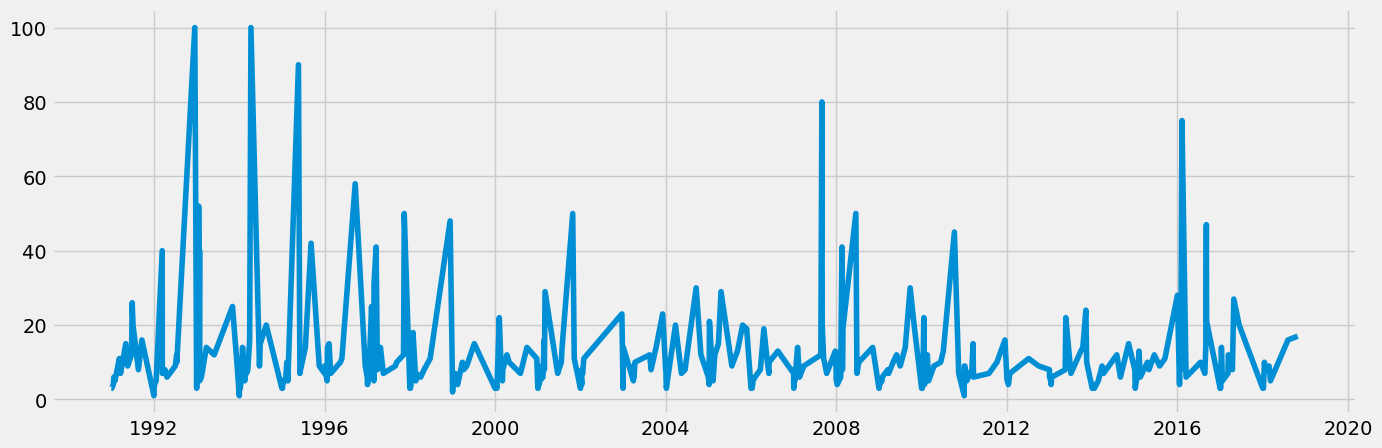

In [65]:
#Plot total_crime over time
plt.figure(figsize=(15,5), dpi=100)
plt.plot(hate_crime_victims_clean)

In [66]:
hate_crime_victims_clean.columns

Index(['total_victims'], dtype='object')

In [67]:
hate_crime_victims_clean.reset_index(inplace=True)

In [68]:
hate_crime_victims_clean.columns

Index(['datetime', 'total_victims'], dtype='object')

In [69]:
hate_crime_victims_clean.set_index('datetime',inplace=True)

In [70]:
hate_crime_victims_clean.index=pd.to_datetime(hate_crime_victims_clean.index)

<Axes: xlabel='datetime'>

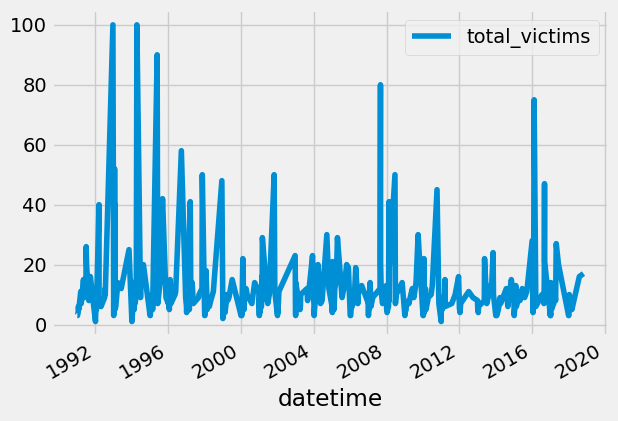

In [71]:
hate_crime_victims_clean.dropna(inplace=True)
hate_crime_victims_clean.plot()

### 3. Time series analysis: decomposition

In [72]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [73]:
result=seasonal_decompose(hate_crime_victims_clean['total_victims'], model='additive', period=28)

<Axes: xlabel='datetime'>

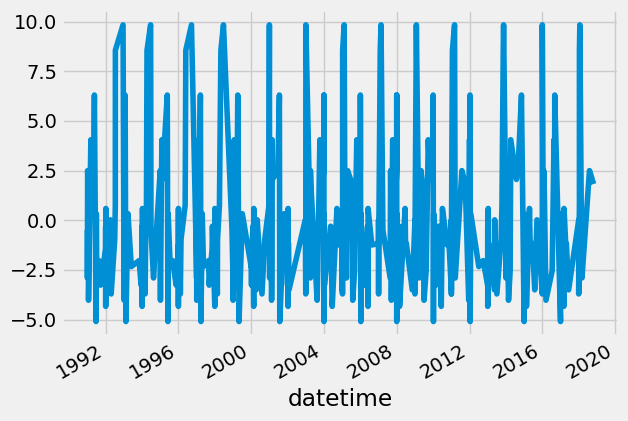

In [74]:
result.seasonal.plot()

<Axes: xlabel='datetime'>

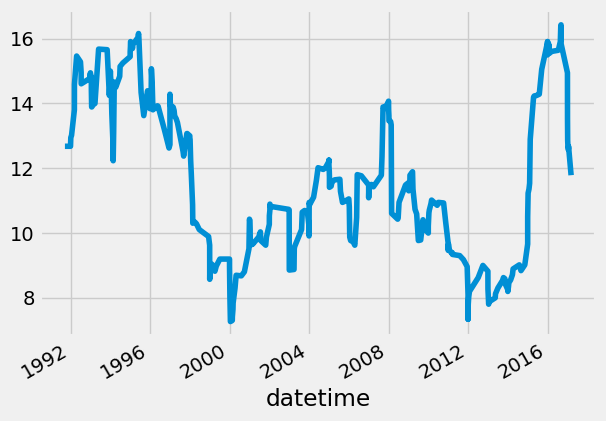

In [75]:
result.trend.plot()

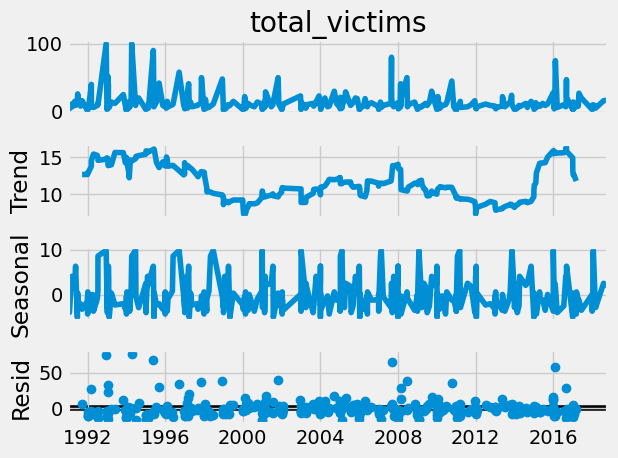

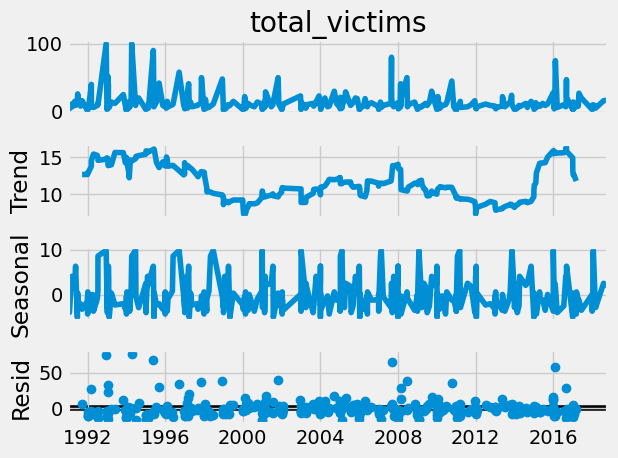

In [76]:
result.plot()

The first chart in the figure above is the data itself (including all of its components). This is called the level; The trend LINE fluctuates with decreases and increases in count of total hate crime victims. The third component is the seasonality. The seasonality plot is similar to the level plot. It can also be speculated that around the end/beginning of a presidental term the number of hate crime victims increase. There isn't much unexplained noise. There are a few outliers, but mainly very smooth and clustered around the line.


### 4. Testing for stationarity

In [77]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(hate_crime_victims_clean['total_victims'])

Dickey-Fuller Stationarity test:
Test Statistic                -1.805058e+01
p-value                        2.640301e-30
Number of Lags Used            0.000000e+00
Number of Observations Used    3.670000e+02
Critical Value (1%)           -3.448294e+00
Critical Value (5%)           -2.869448e+00
Critical Value (10%)          -2.570983e+00
dtype: float64


The test statistic is much smaller than the critical value at 90% confidence interval, which means that the null hypothesis can be rejected. So there is a unit root and the data is stationary.

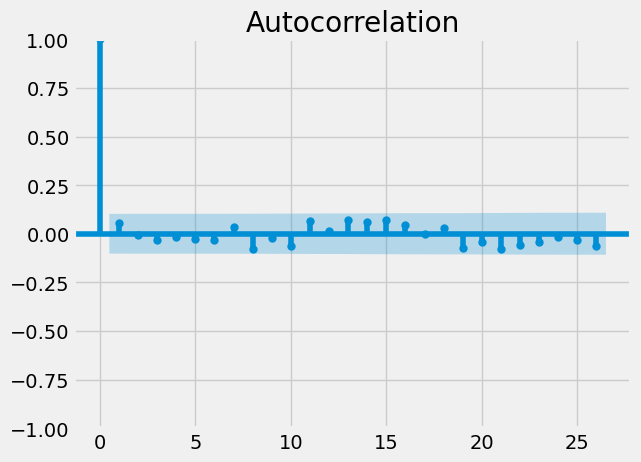

In [78]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(hate_crime_victims_clean)
plt.show()

In [79]:
# exporting data 
df.to_csv(os.path.join(path, 'Prepared dataset', 'hate_crimes_wrangled_5.csv'))